In [1]:
from IPython.display import HTML, Image

HTML("""
<style>
    #notebook-container {
    width: 80% !important;
}
.dataTable {
    width: 100% !important;
}
.dataTables_scrollBody {
    width: 100% !important;
}
.dataTables_scrollHead {
    width: 100% !important;
}
.dataTables_filter {
   float: right !important;
}
.output_html {
    max-width: calc(100%) !important;
}
.rendered{
    font-size: 125%;
}
</style>
""")

html1 = """
    <img src="https://bartable.bart.gov/sites/default/files/styles/body_width_/public/bike%20the%20bridge.jpg" style="margin-left:auto; margin-right:auto"/>
"""
HTML(html1)

# GoBike Data Analysis

## Goals
In this analysis, I aim to uncover any patterns, trends, or insights from a spreadsheet containing 519,000+ rows of data pertaining to bike rentals. The data contains basic information like:
* Start & End times
* Start & End locations & IDs
* Bike IDs
* User information - gender, birth year, customer type

## Some Questions Worth Answering
* Customer demographics
    * What age group uses bikes more often?
    * Which gender rents more bikes?
* Ride statistics
    * Average ride length?
    * When were the most popular times to rent a bike?
* Location demographics
    * Do any stations see more traffic?
    * What are the least used stations?
* Miscellaneous
    * Which bike was used the most/least?

In [2]:
#IMPORT TOOLS & LIBRARIES
import pandas as pd
import numpy as np
import seaborn as sns
import os
import itables
from plotly.subplots import make_subplots

import func

# Data Exploration

In [3]:
# #read in data
output = pd.read_csv('goBike.csv', chunksize=100000)

df = pd.DataFrame()
for chunk in output:
    df = pd.concat([df, chunk])
    
df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender
0,80110,12/31/2021 16:57,1/1/2022 15:12,74,Laguna St at Hayes St,37.776435,-122.426244,43,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male
1,78800,12/31/2021 15:56,1/1/2022 13:49,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female
2,45768,12/31/2021 22:45,1/1/2022 11:28,245,Downtown Berkeley BART,37.870348,-122.267764,245,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN
3,62172,12/31/2021 17:31,1/1/2022 10:47,60,8th St at Ringold St,37.774520,-122.409449,5,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN
4,43603,12/31/2021 14:23,1/1/2022 2:29,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519700 entries, 0 to 519699
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             519700 non-null  int64  
 1   start_time               519700 non-null  object 
 2   end_time                 519700 non-null  object 
 3   start_station_id         519700 non-null  int64  
 4   start_station_name       519700 non-null  object 
 5   start_station_latitude   519700 non-null  float64
 6   start_station_longitude  519700 non-null  float64
 7   end_station_id           519700 non-null  int64  
 8   end_station_name         519700 non-null  object 
 9   end_station_latitude     519700 non-null  float64
 10  end_station_longitude    519700 non-null  float64
 11  bike_id                  519700 non-null  int64  
 12  user_type                519700 non-null  object 
 13  member_birth_year        453159 non-null  float64
 14  memb

In [5]:
df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year
count,519700.000000,519700.000000,519700.000000,519700.000000,519700.000000,519700.000000,519700.000000,519700.000000,453159.000000
mean,1099.009521,95.034245,37.771653,-122.363927,92.184041,37.771844,-122.363236,1672.533079,1980.404787
std,3444.146451,86.083078,0.086305,0.105573,84.969491,0.086224,0.105122,971.356959,10.513488
min,61.000000,3.000000,37.317298,-122.444293,3.000000,37.317298,-122.444293,10.000000,1886.000000
25%,382.000000,24.000000,37.773492,-122.411726,23.000000,37.774520,-122.410345,787.000000,1974.000000
50%,596.000000,67.000000,37.783521,-122.398870,66.000000,37.783830,-122.398525,1728.500000,1983.000000
75%,938.000000,139.000000,37.795392,-122.391034,134.000000,37.795392,-122.391034,2520.000000,1988.000000
max,86369.000000,340.000000,37.880222,-121.874119,340.000000,37.880222,-121.874119,3733.000000,1999.000000


### Observations
There's a lot of data we can take away from the above:
* **Duration**: The average bike ride was ~1100 seconds, or just over 18 minutes
* **Birth Year**: The average birth year is 1980, and 75% of customers were born before 1988
    * Outliers: The oldest birth year is reported as 1886 - user error?
* **Gender**: There are roughly ~3.5x as men male users as female/other users

### Checking for Missing Data
As we can see below, two columns are missing ~12.8% of the data. For simplicity's sake, I removed these entries.

In [6]:
df['start_time'] = pd.to_datetime(df['start_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
func.calc_missing(df)

,column,%_missing,#_rows
0,member_birth_year,12.80,66541.0
1,member_gender,12.79,66462.0


In [7]:
# drops all rows that have at least one NaN
df.dropna(inplace=True)

## Customer Demographics
### Single-Time Users vs. GoBike Subscribers

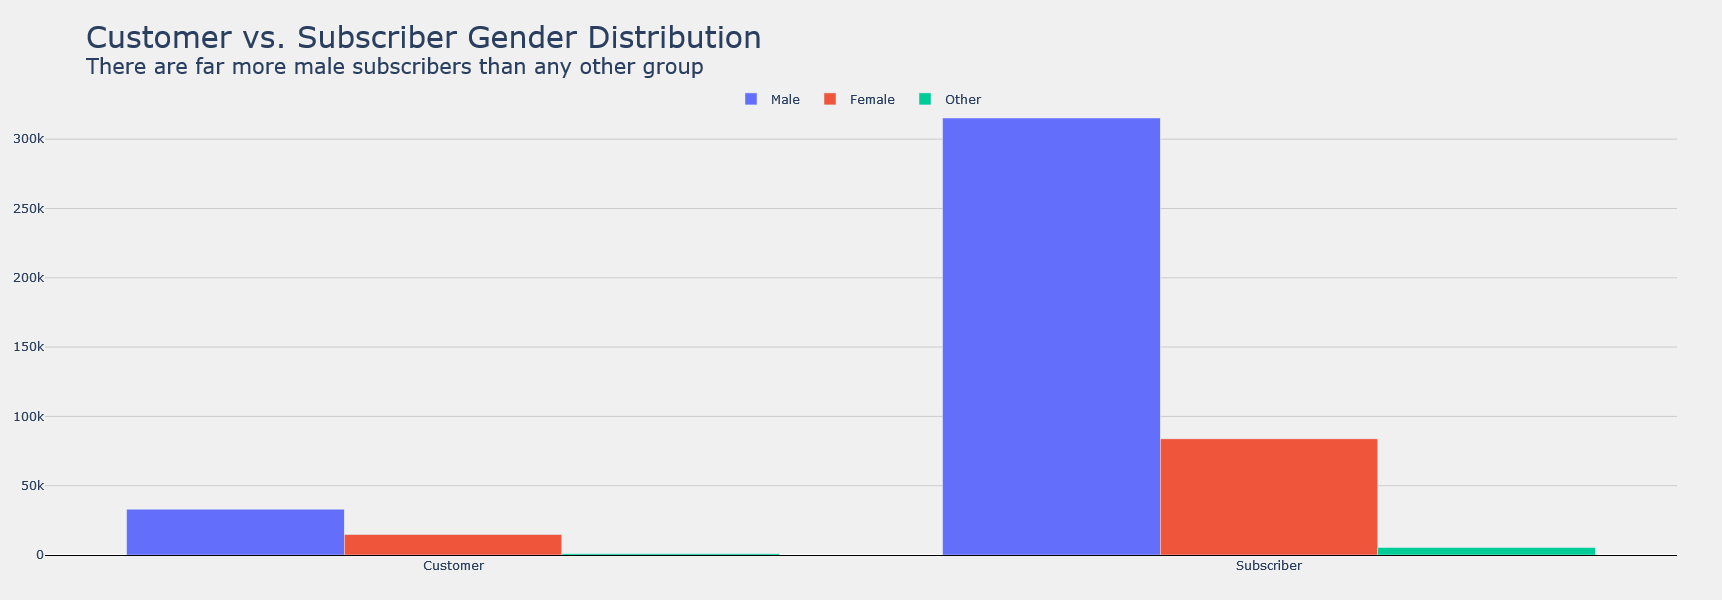

In [8]:
dfu = df.groupby(['user_type', 'member_gender']).size().unstack().reset_index()
dfu = dfu.iloc[:,[0,2,1,3]]
title = "Customer vs. Subscriber Gender Distribution"
sub = "There are far more male subscribers than any other group"
func.plot_gender_dist(dfu, title, sub)

### Age & Gender Distribution

In [9]:
dfg = df.groupby(['member_gender']).size().to_frame(name='Count')
dfg

,Count
member_gender,
Female,98542
Male,348318
Other,6299


In [ ]:
df['member_age'] = df['start_time'].dt.year - df['member_birth_year']
df = df[df['member_age'] <= 100] # removes outliers
df["age_group"] = pd.cut(x=df['member_age'],
                         bins=[18,25,35,45,55,65,75,85,95,130], 
                         labels=["18-24","25-34","35-44","45-54","55-64","65-74","74-84","85-94","95+"])
dfa = df[['member_gender', 'age_group']]

title = "User Age & Gender Distribution"
sub = "Males getween the ages of 25-44 make up the overwhelming majority of users"
func.plot_gender_age(dfa, title, sub)

### Age & Gender vs. Ride Duration

In [ ]:
df = df[df['member_age'] <= 100] # removes outlier
df['duration_minute'] = df['duration_sec'] // 60 # calculate ride minutes

# aggregates mean and count by member_age
dfr = (df.groupby(['member_gender', 'member_age'])
       .agg(avg_duration=('duration_minute', np.mean),
           num_riders=('member_age', np.size))
        .reset_index())

title = "Age & Gender vs. Ride Duration"
sub = "Women tend to ride bikes longer than men across most age groups"
func.plot_gender_dur(dfr, title, sub)

### Observations
* Men between 25-44 are the main customers
* People between 30s-50s tend ride for 12-15 minutes - commuting to/from work?
* Women tend to have longer ride durations compared to men
* Younger folk and seniors have more varied ride durations - less commitments, more free time, etc.

## Date & Time

In [ ]:
print(f'Earliest date: {df["start_time"].min()}')
print(f'  Latest date: {df["start_time"].max()}')

After grouping data by the hour, I decided to bin the hours like so:
* Early Morning: 3:00 - 5:59am
* Morning: 6:00 - 11:59am
* Afternoon: 12:00pm - 4:59pm
* Evening: 5:00 - 8:59pm
* Night: 9:00 - 11:59pm
* Late Night: 12:00am - 2:59am

In [ ]:
dfp = (df.groupby([df['start_time'].dt.month, df['start_time'].dt.hour])['duration_sec'].count()
           .unstack(0)
           .fillna(0)
           .T) 
title = "Total Amounts of Rides by Month"
sub = "As temperatures cool down, the number of rides increases - until winter"
func.plot_month(dfp, title, sub)

### Observations
* Fall seems to be the most popular time to rent bikes - temperatures cool down, but not too chilly yet
* Mornings and evenings see the most rentals for each month - probably due to commute?
* Very few night/late night rentals - weather & safety concerns?

In [ ]:
sub = df[['start_station_latitude', 'start_station_longitude', 
          'end_station_latitude', 'end_station_longitude', 
          'start_station_name', 'end_station_name']]
dfs = func.comb_stations(sub)
title = "Map of Most Used Bike Stations"
sub = "Stations closer to the water or BART stations were more popular"
func.plot_stations(dfs, title, sub)

### Observations
* Most of the traffic is in San Francisco - Market Street
    * More rentals took place near BART stations, and the water - tourism?
* Oakland saw significantly less rentals - maybe due to locals and less tourists?

# Summary
* People between 25-44 tend to rent bikes more often, but ride them for shorter durations.
* People outside that age range tend to rent bikes less often, but ride them for longer durations.
* Women typically ride bikes for longer durations compared to men.
* Mornings and evenings see the most rentals, probably due to people's work commutes.
* More bike rentals occur as summer becomes fall, but slowly drop as fall becomes winter.
* The bike stations closer to major points of interest (BART stations, popular tourist areas) see more rentals.

# Possible Next Steps
* Further explore relationship between gender, age, and duration
    * More granular analysis? Breakdowwn by weekday?
* Pull in weather data and see if correlation exists between rentals
* Analyze start-end paths for genders?

In [ ]:
# df_num = df.select_dtypes(include=np.number)
# def iqr_outliers(df):
#     outlier_indices = []
#     print(" "*20 + "OUTLIER COUNTS PER FEATURE")
#     print("*"*65)
#     for col in df.columns:
#         q1 = np.percentile(df[col], 25)
#         q3 = np.percentile(df[col], 75)
#         iqr = q3-q1
#         lower_tail = q1 - 1.5 * iqr
#         upper_tail = q3 + 1.5 * iqr
#         outlier_index = df[(df[col] < lower_tail) | (df[col] > upper_tail)].index
#         outlier_indices.extend(outlier_index)
        
#         #display nicely
#         count = len(outlier_index)
#         percent = round((count/df.shape[0])*100,2)
#         if count > 0:
#             print(f"{f'{col}:':>30} {f'{count}':>3} {f'({percent}%)':>8}")
#     print(f"{'Total # of outliers:':>30} {f'{len(outlier_indices)}':>6} {f'{(len(outlier_indices)/df.shape[0])*100:.2f}':>8}")
#     # print(f' Total # of outliers: {len(outlier_indices)} ({round((len(outlier_indices)/df.shape[0])*100,2)}%)')
#     return outlier_indices

# outliers = iqr_outliers(df_num)
# # outliers = iqr_outliers(df['duration_minutes'])